In [1]:
import numpy as np
import mne
import pyedflib
from pyedflib import highlevel
from datetime import datetime

In [2]:
filename = 'A01_SE001CB_Train01.edf'
raw_data = mne.io.read_raw_edf(filename, verbose=None)
raw_data.load_data()

Extracting EDF parameters from /Users/zionshane/Desktop/Duke/Research/P300-BCI/P300-BCI/Others/DCC-training/A01_SE001CB_Train01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 35207  =      0.000 ...   137.527 secs...


<RawEDF | A01_SE001CB_Train01.edf, 114 x 35208 (137.5 s), ~30.7 MB, data loaded>

In [3]:
eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], 'EEG')
raw_data.notch_filter(freqs=60, picks=eeg_channels)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


<RawEDF | A01_SE001CB_Train01.edf, 114 x 35208 (137.5 s), ~30.7 MB, data loaded>

The sample dataset includes several “STIM” channels that recorded electrical signals sent from the stimulus delivery computer (as brief DC shifts / squarewave pulses). These pulses (often called "triggers") are used in this dataset to mark experimental events: stimulus onset, stimulus type, and participant response (button press).
The individual STIM channels are combined onto a single channel, in such a way that voltage levels on that channel can be unambiguously decoded as a particular event type. On older Neuromag systems (such as that used to record the sample data) this summation channel was called STI 014, so we can pass that channel name to the mne.find_events function to recover the timing and identity of the stimulus events.

In [4]:
## Spelling Outcomes
current_target_events   = mne.find_events(raw_data, stim_channel='CurrentTarget',
                                          verbose=False)
predicted_target_events = mne.find_events(raw_data, stim_channel='SelectedTarget',
                                          verbose=False)
current_target   = current_target_events[:,2]
predicted_target = predicted_target_events[:,2]

In [5]:
## Extract EEG Epochs (see https://mne.tools/stable/auto_tutorials/epochs/index.html)
# Find stimulus events and target stimulus events
stim_events     = mne.find_events(raw=raw_data, stim_channel='StimulusBegin',
                                  verbose=False)
targstim_events = mne.find_events(raw=raw_data, stim_channel='StimulusType',
                                  verbose=False)
# Label target and non-target epochs
targstim_indices = np.isin(stim_events[:,0], targstim_events[:,0])
stim_events[~targstim_indices,2] = stim_events[~targstim_indices,2] - 1
# Epoch data based on target and non-target epoch labels
t_min,t_max = 0, 0.8 # feature extraction window
event_dict = {'target': 1, 'non_target': 0} # stimulus event labels
epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                    event_id=event_dict, preload=True, baseline=None,
                    verbose=False, proj=False, picks=eeg_channels)

Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_5328/2956810941.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['target'].plot_image(picks=channel_pick,


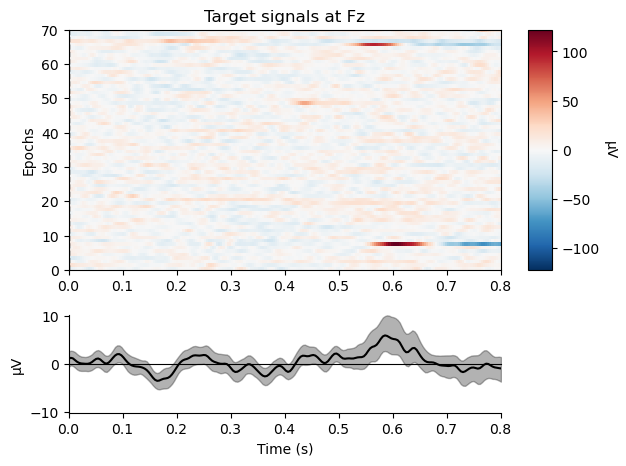

[<Figure size 640x480 with 3 Axes>]

In [6]:
# Plot target signals at a specific channel
channel_pick = raw_data.ch_names[1] # label of first channel
epochs['target'].plot_image(picks=channel_pick,
                            title='Target signals at '+channel_pick[4:])

Not setting metadata
770 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_5328/3887258469.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['non_target'].plot_image(picks=channel_pick,


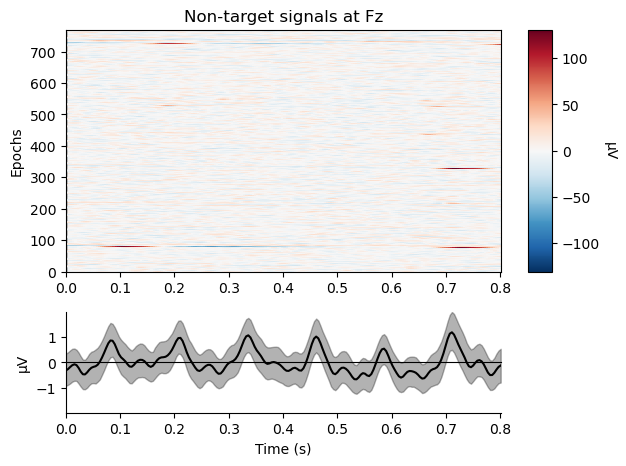

[<Figure size 640x480 with 3 Axes>]

In [7]:
# Plot non-target signals at a specific channel
epochs['non_target'].plot_image(picks=channel_pick,
                                title='Non-target signals at '+channel_pick[4:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


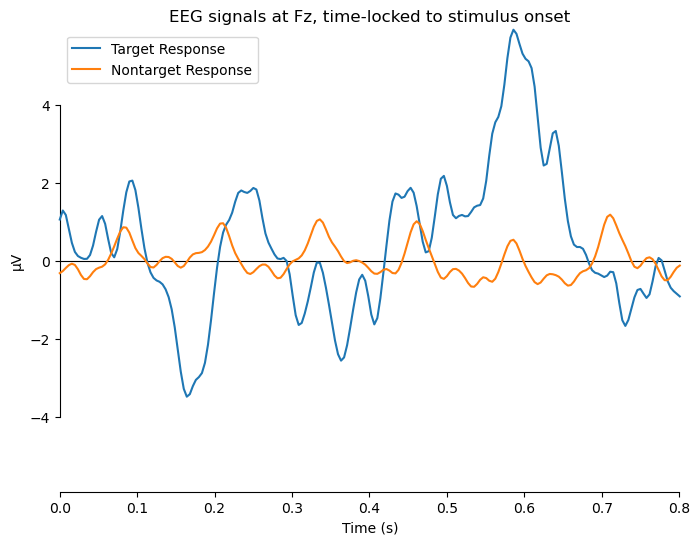

[<Figure size 800x600 with 1 Axes>]

In [8]:
# Alternate visualisation: Average target and nontarget signals
erp_target = epochs['target'].average()
erp_nontarget = epochs['non_target'].average()
mne.viz.plot_compare_evokeds({'Target Response': erp_target,'Nontarget Response': erp_nontarget},
picks=channel_pick, show_sensors=False,
title='EEG signals at '+channel_pick[4:]+', time-locked to stimulus onset')

In [9]:
## Stimulus Presentation Schedule
character_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], '.*_\d*_\d*$')

In [10]:
## Demographics
file_header = highlevel.read_edf_header('A01_SE001CB_Train01.edf')
sex = file_header['gender'] # Sex
other_demo = file_header['patientname'] # Race_Ethnicity_ALSFRS score
birth_date = datetime.strptime(file_header['birthdate'], '%d %b %Y')
start_date = file_header['startdate']
age = (start_date - birth_date).days//365 # Age in years